In [48]:
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils import resample

In [26]:
# Pre-processing: rid of all columns that are mostly unfilled and patients who declined to answer a question
cerv_data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values=["?"])
print(len(cerv_data.columns))
cerv_data = cerv_data.drop(columns =['STDs: Time since last diagnosis','STDs: Time since first diagnosis'])
#cerv_data = cerv_data.dropna()
cols = cerv_data.columns
imp_mean = IterativeImputer(random_state=0)
cerv_data = pd.DataFrame(imp_mean.fit_transform(cerv_data), columns = cols)
#imp_mean.transform(cerv_data)
#print(cerv_data)
x, y = cerv_data.iloc[:,:-4], cerv_data.iloc[:,-4:]
# print(x)
# print(y)

36
      Age  Number of sexual partners  First sexual intercourse  \
0    18.0                        4.0                 15.000000   
1    15.0                        1.0                 14.000000   
2    34.0                        1.0                 20.046165   
3    52.0                        5.0                 16.000000   
4    46.0                        3.0                 21.000000   
..    ...                        ...                       ...   
853  34.0                        3.0                 18.000000   
854  32.0                        2.0                 19.000000   
855  25.0                        2.0                 17.000000   
856  33.0                        2.0                 24.000000   
857  29.0                        2.0                 20.000000   

     Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                   1.0     0.0             0.0                  0.0   
1                   1.0     0.0             0.0             

In [57]:
#balanced data set dataframes
hinsel_pos = cerv_data.loc[cerv_data['Hinselmann'] == 1] #35
schiller_pos = cerv_data.loc[cerv_data['Schiller'] == 1] #74
citology_pos = cerv_data.loc[cerv_data['Citology'] == 1] #44
biopsy_pos = cerv_data.loc[cerv_data['Biopsy'] == 1] #55

hinsel_neg = resample(cerv_data.loc[cerv_data['Hinselmann'] == 0], n_samples = 35) #35
schiller_neg = resample(cerv_data.loc[cerv_data['Schiller'] == 0], n_samples = 74) #74
citology_neg = resample(cerv_data.loc[cerv_data['Citology'] == 0], n_samples = 44) #44
biopsy_neg = resample(cerv_data.loc[cerv_data['Biopsy'] == 0], n_samples = 55) #55

In [82]:
###### Logistic regression ######
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.utils import compute_sample_weight
from sklearn.metrics import confusion_matrix
from utils import *

#hinselmann, schiller, citology, biopsy = y.loc[:, 'Hinselmann'], y.loc[:, 'Schiller'], y.loc[:, 'Citology'], y.loc[:, 'Biopsy']
hinselmann = hinsel_pos.append(hinsel_neg)   #added for balanced dataset
schiller = schiller_pos.append(schiller_neg) #added for balanced dataset
citology = citology_pos.append(citology_neg) #added for balanced dataset
biopsy = biopsy_pos.append(biopsy_neg)       #added for balanced dataset
lr_pipe = Pipeline([('scale', StandardScaler()), ('logreg', LogisticRegression())])

# Direct fitting
def direct_fit_classifier(pipe, x, y, balanced_step_name=None):
    if balanced_step_name:
        fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y)}
    else:
        fit_params = {}
    pipe.fit(x, y, **fit_params)
    return confusion_matrix(y, pipe.predict(x))

# Cross-validation
def cv_classifier(pipe, x, y, cv, balanced_step_name=None):
    ypred = np.empty(x.shape[0])
    for train_i, test_i in cv.split(x):
        if balanced_step_name:
            fit_params = {'{0}__sample_weight'.format(balanced_step_name): compute_sample_weight('balanced', y.iloc[train_i])}
        else:
            fit_params = {}
        pipe.fit(x.iloc[train_i], y.iloc[train_i], **fit_params)
        ypred[test_i] = pipe.predict(x.iloc[test_i])
    return confusion_matrix(y, ypred)

for outcome, name in zip([hinselmann, schiller, citology, biopsy],
                         ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    x = outcome.iloc[:,:-4]      #added for balanced data set
    y = outcome.iloc[:,33]       #added for balanced data set
    direct_cm = direct_fit_classifier(lr_pipe, x, y, 'logreg')
    cv_cm = cv_classifier(lr_pipe, x, y, KFold(shuffle=True), 'logreg')

    display_model_stats(direct_cm, '{0} upon fitting'.format(name))
    display_model_stats(cv_cm, '{0} upon CV'.format(name))
    print(get_f1_score(cv_cm))

0.5517241379310345


0.616822429906542


0.3111111111111111


0.48


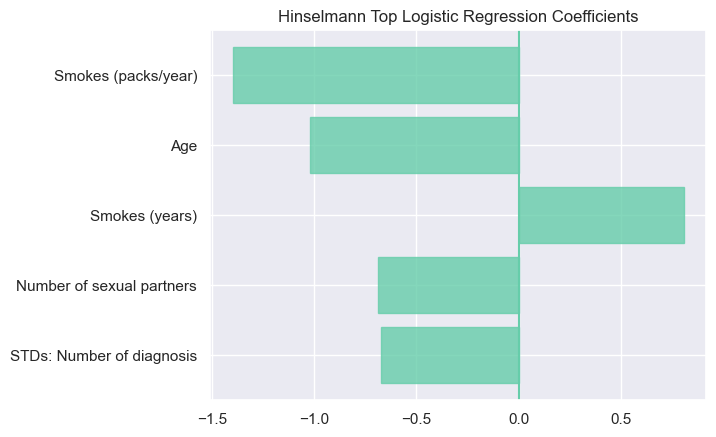

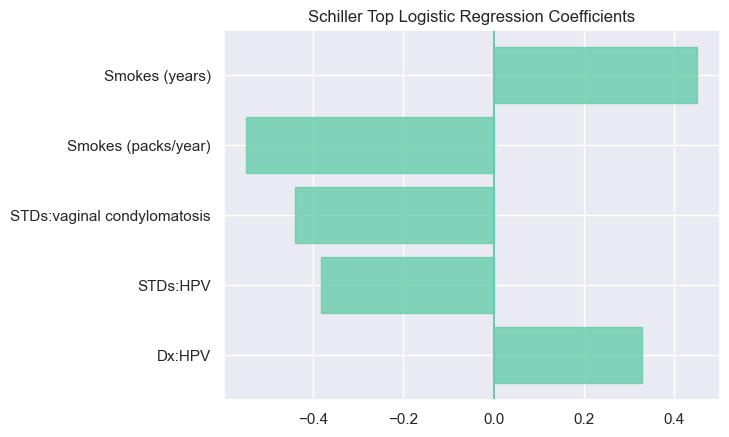

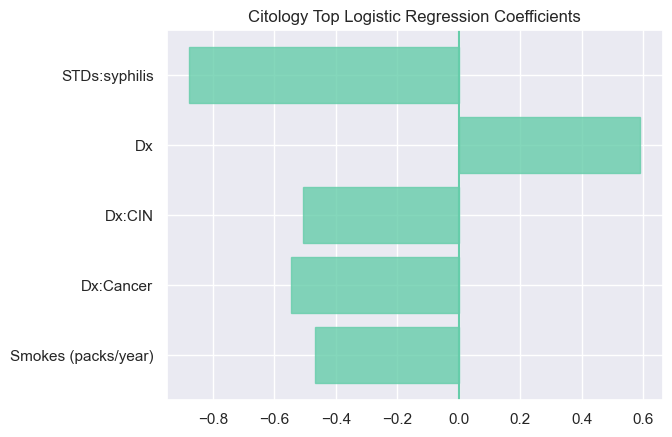

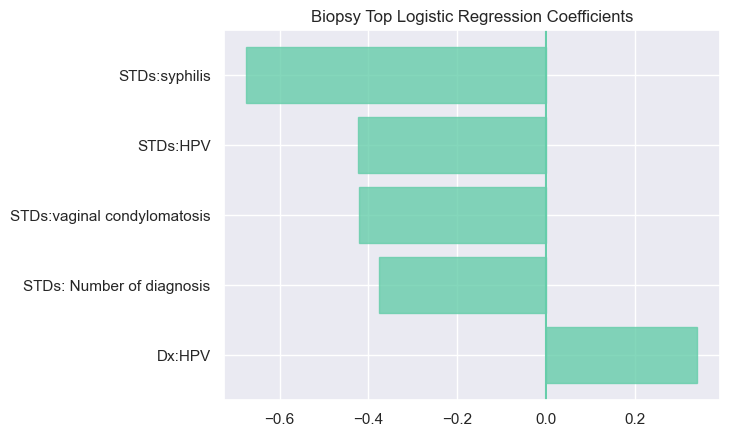

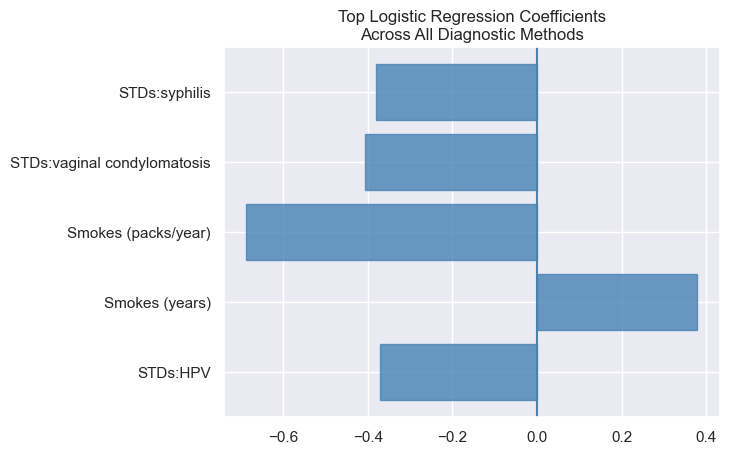

In [34]:
###### Logistic regression coefficients ######

lr_pipe_co = lr_pipe
coef_avg = np.empty(30)
for outcome, name in zip([hinselmann, schiller, citology, biopsy],
                             ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']):
    fit_params = {'logreg__sample_weight': compute_sample_weight('balanced', outcome)}
    lr_pipe_co.fit(x, outcome, **fit_params)
    lr_coefs = lr_pipe_co.named_steps['logreg'].coef_
    coef_avg = coef_avg + lr_coefs
    
    ind = np.argpartition(np.abs(lr_coefs), -5)[0][-5:]
    highest_weights = lr_coefs[0][ind]
    plt.figure()
    plt.barh(range(5), highest_weights, tick_label=x.columns[ind], 
             color='mediumaquamarine', alpha=0.8, ec='mediumaquamarine')
    plt.axvline(x=0, c='mediumaquamarine')
    plt.title(name + " Top Logistic Regression Coefficients")
#     print(lr_coefs[0][ind])
#     print(x.columns[ind])
# print(coef_avg/4)
# print(x.columns)
coef_avg = coef_avg/4
avg_ind = np.argpartition(np.abs(coef_avg), -5)[0][-5:]
avg_weights = coef_avg[0][avg_ind]
plt.figure()
plt.barh(range(5), avg_weights, tick_label=x.columns[avg_ind], 
         color='steelblue', alpha=0.8, ec='steelblue')
plt.axvline(x=0, c='steelblue')
plt.title("Top Logistic Regression Coefficients\nAcross All Diagnostic Methods")
plt.show()

In [28]:
###### Support vector machines ######
#we will have to play with c value and kernel
svc_model = Pipeline([('scale', StandardScaler()), ('svm', SVC(C=1000, kernel='rbf'))])
hinselmann_arr = np.array(hinselmann)
svc_model.fit(x, hinselmann_arr)
hinselmann_predict = svc_model.predict(x)
#print(hinselmann_predict)
print(cv_classifier(svc_model, x, hinselmann, KFold()))

schiller_arr = np.array(schiller)
svc_model.fit(x, schiller_arr)
schiller_predict = svc_model.predict(x)
#print(schiller_predict)
print(cv_classifier(svc_model, x, schiller, KFold()))

citology_arr = np.array(citology)
svc_model.fit(x, citology_arr)
citology_predict = svc_model.predict(x)
#print(citology_predict)
print(cv_classifier(svc_model, x, citology, KFold()))

biopsy_arr = np.array(biopsy)
svc_model.fit(x, biopsy_arr)
biopsy_predict = svc_model.predict(x)
#print(biopsy_predict)
print(cv_classifier(svc_model, x, biopsy, KFold()))


[[810  13]
 [ 34   1]]
[[744  40]
 [ 59  15]]
[[786  28]
 [ 40   4]]
[[776  27]
 [ 48   7]]


In [78]:
tests = [hinselmann, schiller, citology, biopsy]
kernels_options = ['rbf', 'poly']
cv_data = np.zeros((4,2,20))
cv_FN = np.zeros((4,2,20))
cv_FP = np.zeros((4,2,20))
cv_f1 = np.zeros((4,2,20))
cv_mis = np.zeros((4,2,20))
c_values = np.logspace(-4,5,20)
for a in range(4):
    for i, b in enumerate(c_values):
        for c in range(2):
            svc_model = Pipeline([('scale', StandardScaler()), ('svm', SVC(C=b, kernel=kernels_options[c]))])
            x = outcome.iloc[:,:-4]      #added for balanced data set
            tests = outcome.iloc[:,33]       #added for balanced data set
            direct_cm = direct_fit_classifier(svc_model, x, tests)#[a]) for balanced set
            cv_cm = cv_classifier(svc_model, x, tests, KFold()) #tests[a] for balanced data set
            #display_model_stats(direct_cm, '{0} upon fitting'.format(name))
            #display_model_stats(cv_cm, '{0} upon CV'.format(name))
            cv_data[a,c,i] = get_score(cv_cm)
            cv_FN[a,c,i] = get_fn_rate(cv_cm)
            cv_FP[a,c,i] = get_fp_rate(cv_cm)
            cv_f1[a,c,i] = get_f1_score(cv_cm)
            cv_mis[a,c,i] = misclassification(cv_cm)
            print(a, kernels_options[c], b)
            #print(tests[a])
            #print(kernels_options[c])
            #print(c_values[i])
    

0 rbf 0.0001
0 poly 0.0001
0 rbf 0.00029763514416313193
0 poly 0.00029763514416313193
0 rbf 0.0008858667904100823
0 poly 0.0008858667904100823
0 rbf 0.0026366508987303583
0 poly 0.0026366508987303583
0 rbf 0.007847599703514606
0 poly 0.007847599703514606
0 rbf 0.023357214690901212
0 poly 0.023357214690901212
0 rbf 0.06951927961775606
0 poly 0.06951927961775606
0 rbf 0.2069138081114788
0 poly 0.2069138081114788
0 rbf 0.615848211066026
0 poly 0.615848211066026
0 rbf 1.8329807108324339
0 poly 1.8329807108324339
0 rbf 5.455594781168514
0 poly 5.455594781168514
0 rbf 16.23776739188721
0 poly 16.23776739188721
0 rbf 48.32930238571752
0 poly 48.32930238571752
0 rbf 143.8449888287663
0 poly 143.8449888287663
0 rbf 428.1332398719387
0 poly 428.1332398719387
0 rbf 1274.2749857031322
0 poly 1274.2749857031322
0 rbf 3792.690190732246
0 poly 3792.690190732246
0 rbf 11288.378916846883
0 poly 11288.378916846883
0 rbf 33598.18286283774
0 poly 33598.18286283774
0 rbf 100000.0
0 poly 100000.0
1 rbf 0.00

In [ ]:
## F1 score
for a in range(4):
    for b in range(2):
        plt.figure(figsize=(10,5))
        plt.plot(c_values,cv_data[a,b,:], label = 'test accuracy')
        plt.plot(c_values,cv_FN[a,b,:], label = 'FN rate')
        plt.plot(c_values,cv_FP[a,b,:], label = 'FP rate')
        plt.plot(c_values,cv_f1[a,b,:], label = 'F1 score')
        #plt.title('{0} {1}'.format(tests[a].name, kernels_options[b]))
        plt.xscale('log')
        plt.xlabel('Regularization parameter (C)')
        plt.legend()
        plt.show()
        print(np.argmax(cv_f1[a,b,:]))
        print(np.argmin(cv_mis[a,b,:]))